<img src="images/charizard.png" alt="Expert" width="200">

# Expert level

<img src="http://www.animatedgif.net/underconstruction/5consbar2_e0.gif">
<div style="border: 5px solid red; padding: 20px;"><p>I'm currently writing the exercise for this level. It is not done yet, but it will be before the workshop begins!</p></div>
<img src="http://www.animatedgif.net/underconstruction/5consbar2_e0.gif">

Welcome to the expert level!
For this level, I'm assuming you are somewhat familiar with the Python programming language, for example by completing the ['adept'](adapt.ipynb) level, or having done some other projects in Python.
Alternatively, if you have enough experience in other programming languages, you can follow along.
If some aspect of the Python programming language is unclear, I found Jake VanderPlas' ["A whirlwind tour of Python"](http://www.oreilly.com/programming/free/files/a-whirlwind-tour-of-python.pdf) a great reference to quickly look things up.

During the next half hour, we are going to construct a basic pipeline that begins with some raw MEG data and performs a minimum-norm estimate (MNE) of the cortical sources.

## The experiment

I have prepared a bit of MEG data for you. It was recorded while a brave volunteer was in the scanner, listening to auditory beeps and looking at visual checkerboards. The volunteer was staring at a "fixation cross" in the center of a screen in front of him/her. From time to time, beeps sounded from either the left or the right side of his/her head. At other times, a checkerboard would be displayed either to the left or right side of to the cross. The volunteer was instructed to keep his/her eyes fixed on the cross and not directly look at the checkerboards. This way, the checkerboard was presented either to the left or right visual field of the volunteer.

<center>
    <img src="images/sound.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/checkerboard.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/cross.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/checkerboard.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/sound.png" width="100" style="display: inline; transform: scaleX(-1);">
</center>

By analyzing the MEG signal, we should be able to see the activity in the auditory and visual cortices.

## Some housekeeping

First order of business is to import the MNE-Python module `mne` and configure the graphics engine to send all figures to the browser.
Executing the cell below will accomplish this.

In [14]:
# Import the MNE-Python module
import mne
print('MNE-Python imported.')

# Configure the graphics engine
%matplotlib notebook
from mayavi import mlab
mlab.init_notebook('ipy')
print('From now on, all graphics will send to your browser.')

MNE-Python imported.
Notebook initialized with ipy backend.
From now on, all graphics will send to your browser.


## Overview of MNE-Python and how to view the documentation

The MNE-Python software module is subdivided in several sub-modules, all housing classes and functions related to different aspects of data analysis. Here are the sub-modules that are relevant for this exercise:

[`mne`](https://www.martinos.org/mne/stable/python_reference.html#module-mne) - Top level module, containing general purpose classes/functions as well as all sub-modules  
[`mne.io`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.io) - Functions related to loading data in different formats  
[`mne.viz`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.viz) - Functions related to data visualization  
[`mne.minimum_norm`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.minimum_norm) - Classes and functions related to performing minimum norm estimates (MNE)

Documentation of all functions and classes can be found at the [Python API reference](https://www.martinos.org/mne/stable/python_reference.html) page.
For quick access, all class/function names used in this notebook are also links to their respective documentation pages.
To use MNE-Python effectively for your own projects, you need to be able to use the documentation.
Therefore, I'm not going to spell out how to call each function, but instead want you to use the documentation to look up this information.

## Sensor-level analysis

Let's dive in by loading some data and looking at the raw signal coming out of the MEG scanner.
The function to load the FIFF files that are produced by the recording software is called [`mne.io.read_raw_fif`](https://www.martinos.org/mne/stable/generated/mne.io.read_raw_fif.html). Take a look at its documentation. From the function signature we can see the function has one required argument, the name of the file to load, and several optional arguments that we can leave alone for now.

The file with the raw data is `'data/sample-raw.fif'`.
In the cell below, write the line of code to load it using the [`mne.io.read_raw_fif`](https://www.martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function and store the result in a variable called `raw`.

In [2]:
# Write your line of code here
raw = 

If the code was correct, the cell below will visualize the raw data, using an interactive figure.
Click in the scrollbars or use the arrow keys to scroll through the data.

<IPython.core.display.Javascript object>


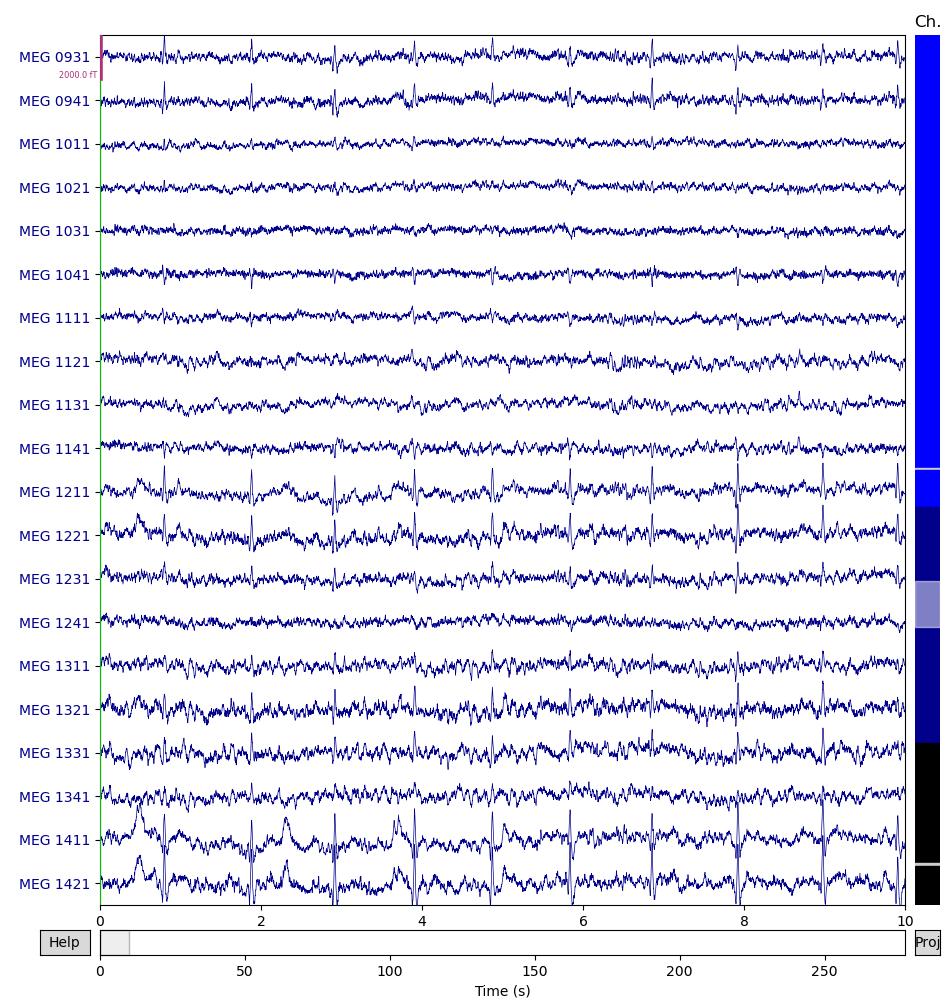

In [18]:
# Lots of MNE-Python objects have a .plot() method, and mne.Raw is no exception
raw.plot();  # Note the semicolon ; at the end, see the text below to find out why

<div style="border: 3px solid #aaccff; margin: 10px 100px; padding: 10px">
    <b>What's with the semicolon ; ?</b>
    
The Jupyter notebook you are working in right now displays the result of the last line in a code cell. The plotting functions return a figure object. Therefore, if the last line of a cell is a call to a plotting function, the figure is displayed twice: one when the function is called, and once more when the figure object is displayed by the Jupyter notebook. By ending a line with a semicolon `;`, we suppress the result produced by that line.
</div>

Browsing through the channels, you will notice there are several channel types:

 * <span style="color: #0000ff">204 MEG gradiometers (102 pairs of two)</span>
 * <span style="color: #00008b">102 MEG magnetometers</span>
 * 60 EEG sensors
 * 9 STIM channels
 * 1 EOG sensor
 
All these channels record different information about the volunteer and the environment. We will first take a look at the STIM channels.

In the figure you just made, scroll down and take a look at channel `STI 014`.
On this channel, the computer that is presenting the stimuli was sending timing information to the MEG equipment.
Whenever a stimulus (checkerboard or beep) was presented, the signal at this channel jumps briefly from 0 to either 1, 2, 3 or 4, indicating the type of stimulus.

We can use this channel to create an "events" matrix: a table listing all the times a stimulus was presented, along with the time of the event and the type of stimulus.
The function to do this is called [`mne.find_events`](https://www.martinos.org/mne/stable/generated/mne.find_events.html), and creates a 2D [NumPy array](https://docs.scipy.org/doc/numpy/user/quickstart.html) containing all the events along with when they occurred and a numerical code indicating the type of event.

The event array can be visualized using the [`mne.viz.plot_events`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_events.html) function.

In the cell below, use the [`mne.find_events`]() function to create an array called `events`, then visualize it using the [`mne.viz.plot_events`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_events.html) function:

<IPython.core.display.Javascript object>


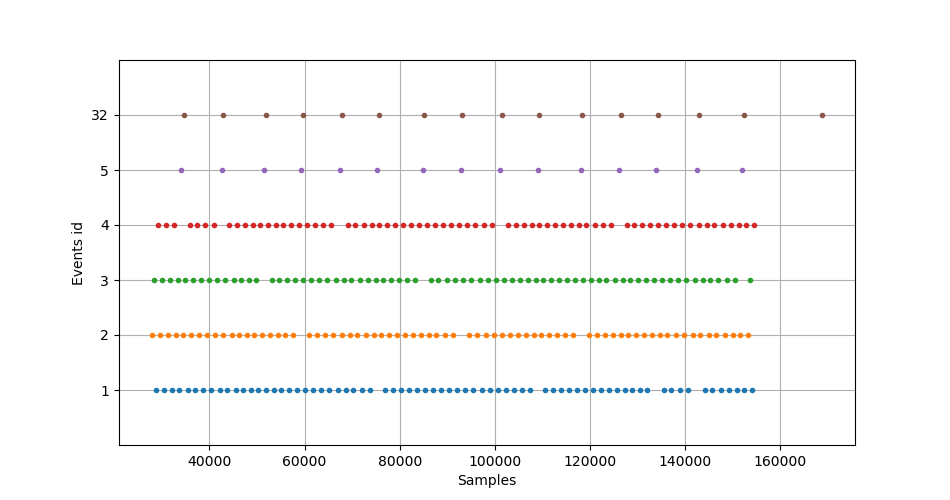

<IPython.core.display.Javascript object>


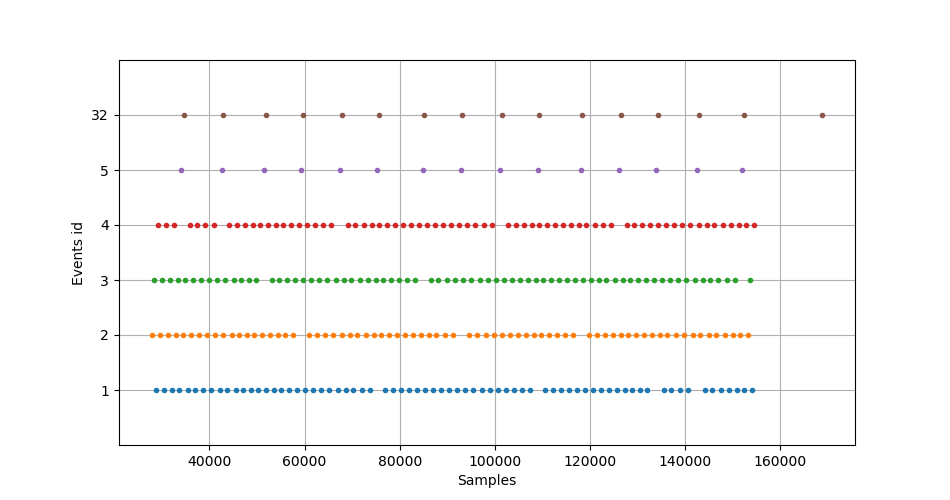

In [17]:
events = mne.find_events(raw)
mne.viz.plot_events(events)

<IPython.core.display.Javascript object>


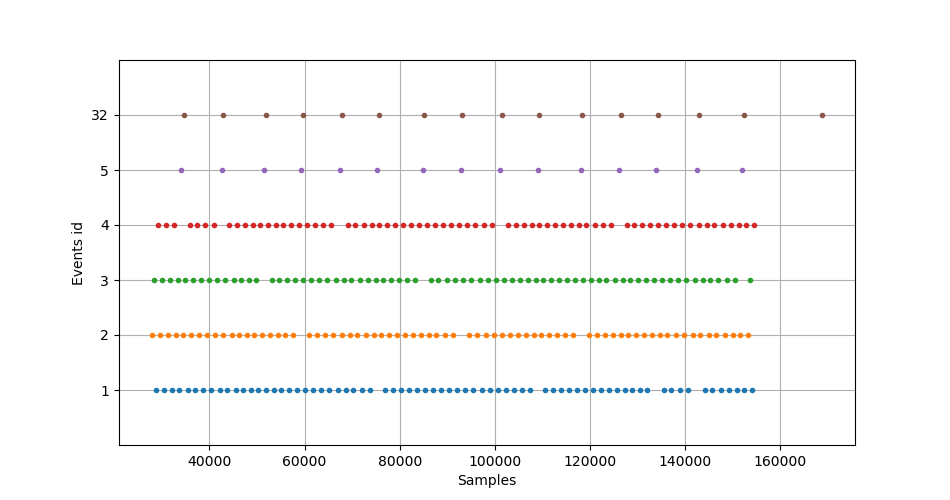

In [10]:
mne.viz.plot_events(events);

In [4]:
event_id = {
    'audio/left': 1,
    'audio/right': 2,
    'visual/left': 3,
    'visual/right': 4
}

In [12]:
epochs = mne.Epochs(raw, events, event_id)

<IPython.core.display.Javascript object>


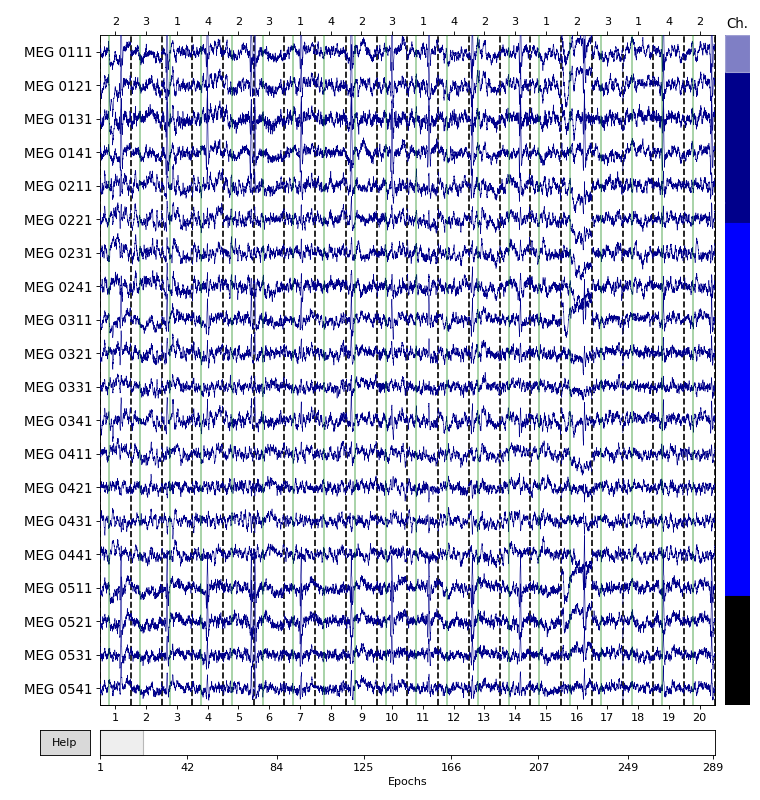

<IPython.core.display.Javascript object>


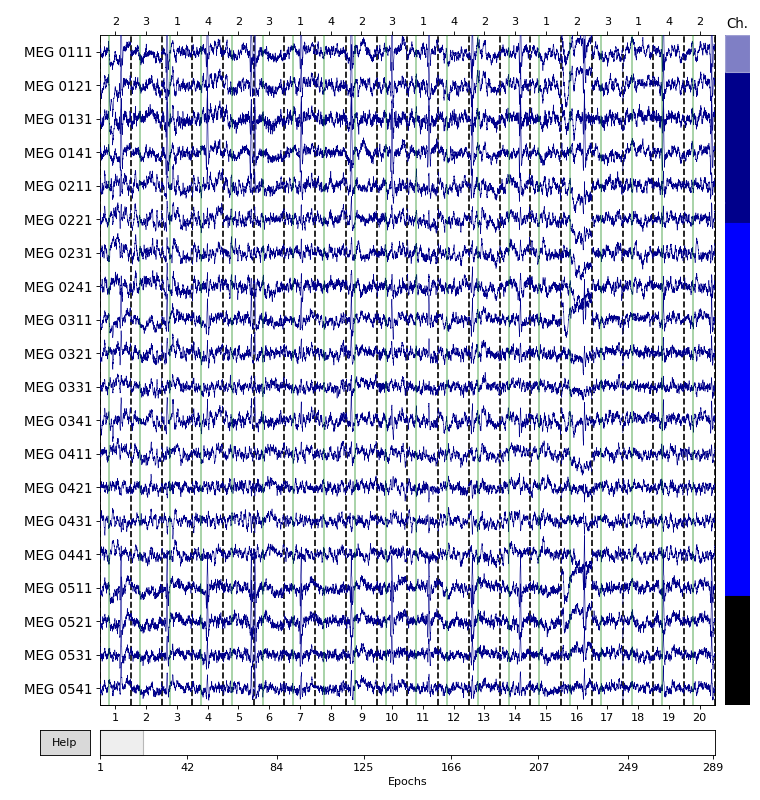

In [13]:
epochs.plot()

In [ ]:
trans = mne.read_trans('data/sample-trans.fif')
mne.viz.plot_alignment(epochs.info, trans, subject='sample', subjects_dir='data/mri')

In [ ]:
src = mne.setup_source_space('sample', subjects_dir='data/mri', add_dist=False)
src.plot(subjects_dir='data/mri')

In [ ]:
bem = mne.read_bem_solution('data/mri/sample/bem/bem-sol.fif')
mne.viz.plot_bem('sample', 'data/mri');

In [ ]:
fwd = mne.make_forward_solution(epochs.info, trans, src, bem)

In [ ]:
noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0, method='shrunk')
mne.viz.plot_cov(noise_cov, epochs.info);

In [ ]:
from mne.minimum_norm import make_inverse_operator
inv = make_inverse_operator(epochs.info, fwd, noise_cov)

In [ ]:
from mne.minimum_norm import apply_inverse

# Apply inverse solution
snr = 3.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(evoked['vl'], inv, lambda2, 'dSPM')

# Plot the source estimate
stc.plot(initial_time=0.1, hemi='both', size=400,
         subjects_dir='data/mri',
         views=['caudal'])